# Basic setup

## preprocessing

In [16]:
#!pip install datasets transformers scikit-learn

In [5]:
import json
import pandas as pd
from datasets import Dataset
import transformers
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
#using the other data sets (other stories) to try out the system
chunk_file = "data/speckled-band-chunk-sentiment.json"
    
words_file = "data/eng-spec.json"

In [7]:
with open(words_file, "r") as f:
    words_data = json.load(f)

with open(chunk_file, "r") as f:
    chunk_data = json.load(f)

In [19]:
from sklearn.model_selection import train_test_split

def extract_sentence_sentiments(data1, data2, test_size=0.1, seed=42):
    """
    Extracts words and overall sentence sentiment, then splits into train/test sets.

    Parameters:
    - data1: dict with sentence tokens and metadata
    - data2: dict with sentiment chunks per sentence (keyed by sid as string)
    - test_size: float, fraction of data to reserve for testing
    - seed: random seed for reproducibility

    Returns:
    - train_data: list of dicts with 'sid', 'text', 'words', and 'sentiment'
    - test_data: list of same dicts, for evaluation
    """
    results = []

    for sentence in data1.get('sentences', []):
        sid = sentence['sid']
        sid_str = str(sid)

        words = [w['word'] for w in sentence.get('words', [])]
        text = sentence.get('text', '')

        sentiment_chunks = data2.get(sid_str)
        if not sentiment_chunks:
            continue  # Skip if no sentiment data

        overall_sentiment = sentiment_chunks[-1]['sentiment']

        results.append({
            'sid': sid,
            'text': text,
            'words': words,
            'sentiment': overall_sentiment
        })

    # Split data
    train_data, test_data = train_test_split(results, test_size=test_size, random_state=seed)

    return train_data, test_data


In [108]:
train_data, test_data = extract_sentence_sentiments(words_data, chunk_data)
test_data

[{'sid': 10110,
  'text': '"\'Never,\' said I.',
  'words': ['"', "'", 'Never', ',', "'", 'said', 'I', '.'],
  'sentiment': 0.0},
 {'sid': 10419,
  'text': "I had never seen my friend's face so grim or his brow so dark as it was when we turned from the scene of this investigation.",
  'words': ['I',
   'had',
   'never',
   'seen',
   'my',
   'friend',
   "'s",
   'face',
   'so',
   'grim',
   'or',
   'his',
   'brow',
   'so',
   'dark',
   'as',
   'it',
   'was',
   'when',
   'we',
   'turned',
   'from',
   'the',
   'scene',
   'of',
   'this',
   'investigation',
   '.'],
  'sentiment': -56.0},
 {'sid': 10564,
  'text': 'The speckled band!" whispered Holmes.',
  'words': ['The', 'speckled', 'band', '!', '"', 'whispered', 'Holmes', '.'],
  'sentiment': 27.0},
 {'sid': 10077,
  'text': 'Shortly after our return to England my mother died--she was killed eight years ago in a railway accident near Crewe.',
  'words': ['Shortly',
   'after',
   'our',
   'return',
   'to',
   'Engl

In [42]:
df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)
print(df_train.head())


     sid                                               text  \
0  10076  She had a considerable sum of money--not less ...   
1  10176         "Yes, there are nearly always some there."   
2  10329  Holmes walked slowly up and down the ill-trimm...   
3  10535   Someone in the next room had lit a dark-lantern.   
4  10547  They say that away down in the village, and ev...   

                                               words  sentiment  
0  [She, had, a, considerable, sum, of, money, --...       31.0  
1  [", Yes, ,, there, are, nearly, always, some, ...      -14.0  
2  [Holmes, walked, slowly, up, and, down, the, i...      -33.0  
3  [Someone, in, the, next, room, had, lit, a, da...      -45.0  
4  [They, say, that, away, down, in, the, village...      -64.0  


In [48]:
def label_sentiment(score):
    if score > 0:
        return "POSITIVE"
    elif score < -0:
        return "NEGATIVE"
    else:
        return "NEUTRAL"

df_train["sentiment_label"] = df_train["sentiment"].apply(label_sentiment)
df_test["sentiment_label"] = df_test["sentiment"].apply(label_sentiment)

In [50]:
label2id = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
id2label = {v: k for k, v in label2id.items()}

df_train["label"] = df_train["sentiment_label"].map(label2id)
df_test["label"] = df_test["sentiment_label"].map(label2id)


In [52]:
train_dataset = Dataset.from_pandas(df_train[["text", "label"]])
test_dataset = Dataset.from_pandas(df_test[["text", "label"]])

In [54]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [64]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


Map: 100%|█████████████████████████████| 60/60 [00:00<00:00, 7991.69 examples/s]


## model training

In [234]:
#!pip install evaluate
#!pip install seqeval
#!pip install torch
#!pip install "accelerate>=0.26.0"

In [66]:
import evaluate
import numpy as np
model_checkpoint = "bert-base-uncased"
task = "sentiment_analysis"
batch_size = 16

In [70]:
from transformers import (
    set_seed, 
    TrainingArguments, 
    Trainer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    AutoTokenizer
)

#put your seed
SEED = 23
set_seed(SEED)

model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    eval_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    seed=SEED,
    report_to=None,
)


In [72]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
metric = evaluate.load("seqeval")
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=3,  # NEGATIVE, NEUTRAL, POSITIVE
    id2label={0:"NEGATIVE",1:"NEUTRAL",2:"POSITIVE"},
    label2id={"NEGATIVE":0,"NEUTRAL":1,"POSITIVE":2}
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
label_list = ["NEGATIVE", "NEUTRAL", "POSITIVE"]

In [87]:
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(p):
    logits, labels = p
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }

In [83]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,       
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/var/folders/pk/23rj3vrj73x83046rkqn9g100000gn/T/ipykernel_2539/601068247.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [89]:
trainer.train()

/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.997316,0.516667,0.449082,0.516667,0.428335
2,No log,0.902164,0.583333,0.598480,0.583333,0.544206
3,No log,0.874453,0.666667,0.679929,0.666667,0.646371


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=102, training_loss=0.7423139085956648, metrics={'train_runtime': 124.2654, 'train_samples_per_second': 13.012, 'train_steps_per_second': 0.821, 'total_flos': 141818132155392.0, 'train_loss': 0.7423139085956648, 'epoch': 3.0})

In [91]:
trainer.save_model('sent_level_model')
trainer.tokenizer.save_pretrained('sent_level_model')

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


('sent_level_model/tokenizer_config.json',
 'sent_level_model/special_tokens_map.json',
 'sent_level_model/vocab.txt',
 'sent_level_model/added_tokens.json',
 'sent_level_model/tokenizer.json')

In [93]:
model = AutoModelForTokenClassification.from_pretrained("sent_level_model")
tokenizer = AutoTokenizer.from_pretrained("sent_level_model")

In [95]:
trainer.evaluate()

/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.8744529485702515,
 'eval_accuracy': 0.6666666666666666,
 'eval_precision': 0.6799291938997821,
 'eval_recall': 0.6666666666666666,
 'eval_f1': 0.6463713929632825,
 'eval_runtime': 1.3287,
 'eval_samples_per_second': 45.156,
 'eval_steps_per_second': 3.01,
 'epoch': 3.0}

In [101]:
predictions, labels, _ = trainer.predict(test_dataset) #data set
predictions = np.argmax(predictions, axis=1)

/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


## model evaluation

In [259]:
#!pip install matplotlib

In [103]:
import csv

def save_sentence_level_predictions(texts, predictions, gold_labels, label_list, output_file_path):
    """
    Save sentence-level predictions with their texts and gold labels to a TSV file.

    Args:
        texts: List of sentence strings.
        predictions: List or array of predicted label IDs (one per sentence).
        gold_labels: List or array of true label IDs (one per sentence).
        label_list: List of string labels, where index corresponds to label ID.
        output_file_path: Path to save the TSV file.

    Returns:
        None
    """
    with open(output_file_path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerow(['sentence', 'prediction', 'gold_label'])

        for text, pred_id, gold_id in zip(texts, predictions, gold_labels):
            pred_label = label_list[pred_id]
            gold_label = label_list[gold_id]
            writer.writerow([text, pred_label, gold_label])

    print(f"Sentence-level results saved to {output_file_path}")


In [105]:
predictions_raw, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions_raw, axis=1)  # shape (num_samples,)

# Assuming you have the original sentences:
texts = [example['text'] for example in test_dataset]

save_sentence_level_predictions(texts, predictions, labels, label_list, "sentence_predictions.tsv")


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Sentence-level results saved to sentence_predictions.tsv


In [117]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_sentence_predictions(predictions, labels, label_list):
    """
    Evaluate sentence-level predictions and print metrics.

    Args:
        predictions: numpy array or list of predicted label IDs
        labels: numpy array or list of true label IDs
        label_list: list of label strings, e.g. ["NEGATIVE", "NEUTRAL", "POSITIVE"]
    """
    # Convert IDs to label strings
    pred_labels = [label_list[p] for p in predictions]
    true_labels = [label_list[l] for l in labels]

    accuracy = accuracy_score(true_labels, pred_labels)
    report = classification_report(true_labels, pred_labels, target_names=label_list, digits=4)

    cm = confusion_matrix(true_labels, pred_labels, labels=label_list)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)
    disp.plot(cmap=plt.cm.Purples, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()


Accuracy: 0.6667
Classification Report:
               precision    recall  f1-score   support

    NEGATIVE     0.6389    0.9200    0.7541        25
     NEUTRAL     0.7143    0.3571    0.4762        14
    POSITIVE     0.7059    0.5714    0.6316        21

    accuracy                         0.6667        60
   macro avg     0.6864    0.6162    0.6206        60
weighted avg     0.6799    0.6667    0.6464        60



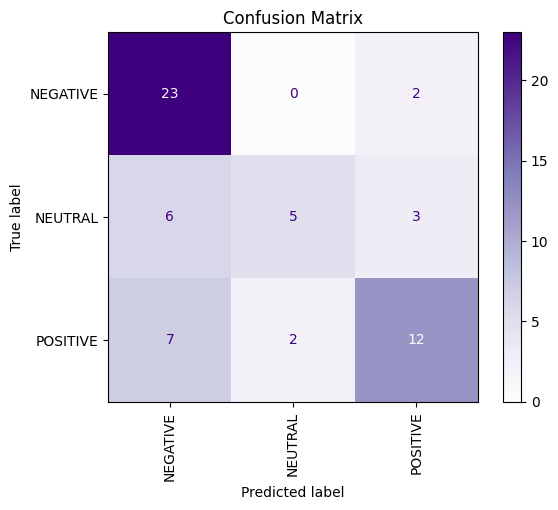

In [119]:
evaluate_sentence_predictions(predictions, labels, label_list)
